In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

import seaborn as sns
sns.set()

Using TensorFlow backend.


# Data 

In [2]:
data = pd.read_csv('D:/IITM/DeepCache/synthetic dataset/syntheticDataset_O50.csv')
data.head()

,object_ID,request_time
0,5,2.961472
1,25,3.274127
2,2,3.785475
3,2,4.455687
4,4,5.288994


In [3]:
data = np.array(data)
req = data[:,0]

len(data)

292146

In [4]:
# to find the probability of occurrence of Oi object is caculated as Ni/1000
# where Ni is number of occurrence of Oi in past 1k req

count = np.zeros(50)
for i in range(1000):
    for j in range(50):
        if req[i] == j+1:
            count[j] += 1

prob = []            
for i in range(1000,len(req)):
    t = int(req[i] - 1)
    count[t] += 1
    t = int(req[i-1000] - 1)
    count[t] -= 1
    prob.append(count/1000)

prob = np.array(prob)
prob.shape

(291146, 50)

In [5]:
encoder_input_data = prob[:290000,:].reshape(20,-1,50) # total samples = 20
batch_size = 14500
decoder_target_data = []
for i in range(1,21):
    temp = []
    for j in range(10): # to predict next 10 req for every batch
        temp.append(prob[(batch_size*i) + j,:])
    decoder_target_data.append(temp)    

decoder_target_data = np.array(decoder_target_data).reshape(20,10,-1)

print(encoder_input_data.shape,decoder_target_data.shape)

(20, 14500, 50) (20, 10, 50)


In [6]:
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[1:,:,:] = decoder_target_data[:-1,:,:]
decoder_input_data[0,:,:] = encoder_input_data[-1,-1,:]
decoder_input_data.shape

(20, 10, 50)

# Model

In [7]:
latent_dim = 128 # LSTM hidden units
dropout = 0.1

In [8]:
encoder_inputs = Input(shape=(None, 50)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
decoder_inputs = Input(shape=(None, 50)) 
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)


In [10]:
#decoder_dense = Dense(decoder_outputs) # 1 continuous output at each timestep
decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)


In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 91648       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  91648       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

# Compile The Model

In [13]:
model.compile(Adam(), loss='mean_squared_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=30)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
20/20 [==============================] - 40s 2s/step - loss: 8.8332e-04
Epoch 2/30
20/20 [==============================] - 40s 2s/step - loss: 8.8299e-04
Epoch 3/30
20/20 [==============================] - 41s 2s/step - loss: 8.8231e-04
Epoch 4/30
20/20 [==============================] - 38s 2s/step - loss: 8.8124e-04
Epoch 5/30
20/20 [==============================] - 39s 2s/step - loss: 8.8072e-04
Epoch 6/30
20/20 [==============================] - 42s 2s/step - loss: 8.7986e-04
Epoch 7/30
20/20 [==============================] - 39s 2s/step - loss: 8.7863e-04
Epoch 8/30
20/20 [==============================] - 39s 2s/step - loss: 8.7820e-04
Epoch 9/30
20/20 [==============================] - 39s 2s/step - loss: 8.7723e-04
Epoch 10/30
20/20 [==============================] - 39s 2s/step - loss: 8.7620e-04
Epoch 11/30
20/20 [==============================] - 40s 2s/step - loss: 

# Testing The Model 

In [14]:
encoder_model = Model(encoder_inputs, encoder_states)
pred_steps = 10

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [15]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 50))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, :] = input_seq[0, -1, :]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,50))
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,:] = output[0,0,:]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 50))
        target_seq[0, 0, :] = output[0,0,:]

        # Update states
        states_value = [h, c]

    return decoded_seq

# fake request generation

In [16]:
len(prob)

291146

In [17]:
(290500-14500)/1000

276.0

In [18]:
prediction = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    prediction.append(decode_sequence(prob[i*276:i*276 + 14500,:].reshape(1,14500,50)))

0
100
200
300
400
500
600
700
800
900


In [19]:
prediction = np.array(prediction).reshape(-1,10,50)
prediction.shape

(1000, 10, 50)

In [20]:
prediction[0][0]

array([0.01916919, 0.02022471, 0.02073711, 0.01984273, 0.02004083,
       0.01990715, 0.01917768, 0.01917634, 0.01969538, 0.02028476,
       0.02047934, 0.01970672, 0.02028381, 0.01992419, 0.01976428,
       0.01994989, 0.01993839, 0.02072443, 0.01962294, 0.01951021,
       0.02023741, 0.0205022 , 0.02174192, 0.01986323, 0.01920103,
       0.01937234, 0.01952998, 0.02107536, 0.02118498, 0.01954782,
       0.02009609, 0.01967938, 0.02009047, 0.02000693, 0.02029076,
       0.01977979, 0.0196945 , 0.01988705, 0.01951085, 0.01966073,
       0.02091358, 0.02034567, 0.01864891, 0.02009245, 0.0209494 ,
       0.0204429 , 0.01984533, 0.01993899, 0.01999351, 0.0197164 ])

In [39]:
fake_request = []
for i in range(1000):
    temp = []
    for j in range(10):
        for k in range(50):
            if prediction[i,j,k] > sorted(prediction[i,j],reverse = 1)[5]:
                temp.append(k)        
    fake_request.append(temp)  
fake_request = np.array(fake_request) 
fake_request.shape

(1000, 50)

In [56]:
290500 + 1000*50

340500

In [79]:
request = []
for i in range(14500):
    request.append(req[i])
for i in range(50):
    request.append(fake_request[0][i])
for i in range(1000):
    for j in range(276 + 50):
        if j < 276:
            request.append(req[14500 + j + 276*i])
        elif(i>0):
            request.append(fake_request[i,j-276])
request = np.array(request)
request.shape

(340500,)

In [80]:
request[14500]

22.0

# LRU Caching

In [81]:
import time
import urllib
import urllib.request
from functools import lru_cache
@lru_cache(maxsize=5)
def get_url(resource):
    try:
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False

In [82]:
hit_LRU = []
req = list(req)
for i in range(len(req)):
    get_url(req[i])
    hit_LRU.append(get_url.cache_info().hits)
get_url.cache_info()

CacheInfo(hits=88253, misses=203893, maxsize=5, currsize=5)

In [88]:
import time
import urllib
import urllib.request
from functools import lru_cache
@lru_cache(maxsize=5)
def get_url(resource):
    try:
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False

In [89]:
hit_deepcache = []
for i in range(len(req)):
    get_url(request[i])
    hit_deepcache.append(get_url.cache_info().hits)
get_url.cache_info()

CacheInfo(hits=109671, misses=182475, maxsize=5, currsize=5)

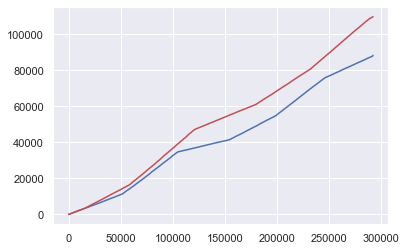

In [90]:
plt.plot(hit_LRU,'b')
plt.plot(hit_deepcache,'r')